# 🗞️ Fine-Tuning BERT on AG News with PyTorch

---

## 📚 What You'll Learn

In this notebook, we'll fine-tune **bert-base-cased** on the **fancyzhx/ag_news** dataset for news topic classification using a **custom PyTorch training loop**. By the end of this notebook, you'll understand:

1. **Custom Training Loops** - Implementing training from scratch with PyTorch
2. **AG News Dataset** - A 4-class news topic classification dataset
3. **DataLoaders** - Efficiently batching and shuffling data
4. **Learning Rate Scheduling** - Implementing linear decay
5. **Model Evaluation** - Calculating accuracy and visualizing training progress

---

## 🧠 About BERT

**BERT** (Bidirectional Encoder Representations from Transformers) is a pretrained language model that learns contextual word representations. Key features:

| Aspect | Description |
|--------|-------------|
| Architecture | Transformer Encoder |
| Training Objective | Masked Language Modeling + Next Sentence Prediction |
| Parameters (base) | 110M |
| Max Sequence Length | 512 tokens |

---

## 📰 About AG News Dataset

The AG News dataset is a collection of news articles for topic classification:

- **4 Classes**: World (0), Sports (1), Business (2), Sci/Tech (3)
- **Training Samples**: 120,000
- **Test Samples**: 7,600
- **Balanced**: 30,000 samples per class in training set

---

## 🛠️ Setup & Installation

Let's start by installing and importing the necessary libraries.

In [1]:
# Install required packages (uncomment if needed)
# !pip install transformers datasets torch torchmetrics matplotlib tqdm -q

In [2]:
# Import essential libraries
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torchmetrics import Accuracy
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [4]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"🚀 Using CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Using Apple Silicon MPS")
else:
    device = torch.device("cpu")
    print("💻 Using CPU (training will be slower)")

print(f"Device selected: {device}")

🚀 Using CUDA GPU
Device selected: cuda


---

## 📊 Part 1: Loading the AG News Dataset

We'll load the AG News dataset from the `fancyzhx/ag_news` repository on Hugging Face.

In [5]:
# Load the AG News dataset
print("📦 Loading AG News dataset...")
dataset = load_dataset("fancyzhx/ag_news")

print("\n📊 AG News Dataset Structure:")
print(dataset)

📦 Loading AG News dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]


📊 AG News Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [6]:
# Define the label names for AG News
label_names = {
    0: "🌍 World",
    1: "⚽ Sports",
    2: "💼 Business",
    3: "🔬 Sci/Tech"
}

# Examine a sample from each class
print("📰 Sample News Articles:")
print("=" * 70)

for label_id in range(4):
    for sample in dataset['train']:
        if sample['label'] == label_id:
            print(f"\n{label_names[label_id]}:")
            print(f"   {sample['text'][:120]}...")
            break

📰 Sample News Articles:

🌍 World:
   Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large number...

⚽ Sports:
   Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter frees...

💼 Business:
   Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics,...

🔬 Sci/Tech:
   'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeism a little high\on Tuesday among the...


In [7]:
# Use a subset for faster training (you can use full dataset for production)
# Comment out these lines to train on the full dataset
TRAIN_SIZE = 5000  # 5000 samples for training
TEST_SIZE = 1000   # 1000 samples for testing

dataset["train"] = dataset["train"].select(range(TRAIN_SIZE))
dataset["test"] = dataset["test"].select(range(TEST_SIZE))

print(f"📉 Using subset for faster training:")
print(f"   Training samples: {len(dataset['train']):,}")
print(f"   Test samples: {len(dataset['test']):,}")

📉 Using subset for faster training:
   Training samples: 5,000
   Test samples: 1,000


---

## 🔤 Part 2: Tokenization

Next, we'll tokenize the dataset using BERT's tokenizer.

In [8]:
# Define the model checkpoint
MODEL_CHECKPOINT = "bert-base-cased"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

print(f"✅ Loaded tokenizer for: {MODEL_CHECKPOINT}")
print(f"   Vocabulary size: {tokenizer.vocab_size:,} tokens")
print(f"   Model max length: {tokenizer.model_max_length}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

✅ Loaded tokenizer for: bert-base-cased
   Vocabulary size: 28,996 tokens
   Model max length: 512


In [9]:
# Let's see tokenization in action
sample_text = "Tech giant Apple unveils new iPhone with AI-powered features."

# Tokenize the sample
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.encode(sample_text)

print("🔤 Tokenization Example:")
print(f"   Original: {sample_text}")
print(f"\n   Tokens: {tokens}")
print(f"\n   Token IDs: {token_ids}")
print(f"\n   Number of tokens: {len(tokens)}")

🔤 Tokenization Example:
   Original: Tech giant Apple unveils new iPhone with AI-powered features.

   Tokens: ['Tech', 'giant', 'Apple', 'un', '##ve', '##ils', 'new', 'iPhone', 'with', 'AI', '-', 'powered', 'features', '.']

   Token IDs: [101, 7882, 4994, 7302, 8362, 2707, 8825, 1207, 19641, 1114, 19016, 118, 5605, 1956, 119, 102]

   Number of tokens: 14


In [10]:
# Define the tokenization function
def tokenize_function(examples):
    """
    Tokenizes the text with padding and truncation.
    """
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=256
    )

# Apply tokenization to the entire dataset
print("⏳ Tokenizing dataset...")
tokenized_datasets = dataset.map(tokenize_function, batched=True)
print("✅ Tokenization complete!")

# View the new structure
print("\n📊 Tokenized Dataset Keys:")
print(tokenized_datasets['train'][0].keys())

⏳ Tokenizing dataset...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

✅ Tokenization complete!

📊 Tokenized Dataset Keys:
dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])


In [11]:
# Prepare the dataset for PyTorch

# Remove the text column (model doesn't need raw text)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# Rename label to labels (expected by the model)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set format to PyTorch tensors
tokenized_datasets.set_format("torch")

print("✅ Dataset formatted for PyTorch")
print(f"   Keys: {tokenized_datasets['train'][0].keys()}")

✅ Dataset formatted for PyTorch
   Keys: dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])


---

## 📦 Part 3: Creating DataLoaders

DataLoaders help us iterate over batches of data efficiently.

In [12]:
# Define batch size
BATCH_SIZE = 8  # Adjust based on your GPU memory

# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=BATCH_SIZE
)

eval_dataloader = DataLoader(
    tokenized_datasets["test"],
    batch_size=BATCH_SIZE
)

print(f"✅ DataLoaders created!")
print(f"   Training batches: {len(train_dataloader):,}")
print(f"   Evaluation batches: {len(eval_dataloader):,}")
print(f"   Batch size: {BATCH_SIZE}")

✅ DataLoaders created!
   Training batches: 625
   Evaluation batches: 125
   Batch size: 8


---

## 🧠 Part 4: Loading the Pretrained Model

We'll load BERT and configure it for our 4-class classification task.

In [13]:
# Define label mappings
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label2id = {"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3}

# Load the model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=4,
    id2label=id2label,
    label2id=label2id
)

# Move model to device
model.to(device)

print(f"✅ Model loaded and moved to {device}")
print(f"   Model type: {type(model).__name__}")
print(f"   Number of parameters: {model.num_parameters():,}")

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded and moved to cuda
   Model type: BertForSequenceClassification
   Number of parameters: 108,313,348


---

## ⚙️ Part 5: Setting Up Optimizer and Scheduler

We'll use AdamW optimizer with a linear learning rate scheduler.

In [14]:
# Hyperparameters
LEARNING_RATE = 5e-5
NUM_EPOCHS = 3

# Calculate total training steps
num_training_steps = NUM_EPOCHS * len(train_dataloader)

# Create optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Create linear learning rate scheduler
lr_scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda current_step: (1 - current_step / num_training_steps)
)

print(f"✅ Optimizer and scheduler configured!")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Number of epochs: {NUM_EPOCHS}")
print(f"   Total training steps: {num_training_steps:,}")

✅ Optimizer and scheduler configured!
   Learning rate: 5e-05
   Number of epochs: 3
   Total training steps: 1,875


---

## 🏋️ Part 6: Custom Training Loop

Now we implement the training loop from scratch. This gives us full control over the training process.

In [15]:
def train_model(model, train_dataloader, num_epochs, optimizer, lr_scheduler):
    """
    Custom training function for fine-tuning BERT.
    
    Returns:
        list: Training losses per epoch
    """
    # Track training losses
    train_losses = []
    
    # Create progress bar
    progress_bar = tqdm(range(num_training_steps), desc="Training")
    
    # Set model to training mode
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        for batch in train_dataloader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss
            
            # Backward pass
            loss.backward()
            
            # Accumulate loss
            total_loss += loss.item()
            
            # Update weights
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
            # Update progress bar
            progress_bar.update(1)
        
        # Calculate average loss for this epoch
        avg_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        
        print(f"\n📊 Epoch {epoch + 1}/{num_epochs} - Average Loss: {avg_loss:.4f}")
    
    return train_losses

---

## 📐 Part 7: Evaluation Function

Let's create a function to evaluate our model's performance.

In [16]:
def evaluate_model(model, eval_dataloader):
    """
    Evaluates the model on the test set.
    
    Returns:
        float: Accuracy score
    """
    # Create accuracy metric
    metric = Accuracy(task="multiclass", num_classes=4).to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    print("📊 Evaluating model...")
    
    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(**batch)
            
            # Get predictions
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            
            # Update metric
            metric(predictions, batch["labels"])
    
    # Compute final accuracy
    accuracy = metric.compute()
    
    return accuracy.item()

---

## 🚀 Part 8: Train the Model!

Let's run the training loop and fine-tune our model.

In [17]:
# Start training
print("🚀 Starting fine-tuning BERT on AG News dataset...")
print(f"   Training on {len(train_dataloader.dataset):,} samples for {NUM_EPOCHS} epochs")
print("=" * 70)

train_losses = train_model(
    model=model,
    train_dataloader=train_dataloader,
    num_epochs=NUM_EPOCHS,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler
)

print("\n" + "=" * 70)
print("✅ Training complete!")

🚀 Starting fine-tuning BERT on AG News dataset...
   Training on 5,000 samples for 3 epochs


Training:   0%|          | 0/1875 [00:00<?, ?it/s]


📊 Epoch 1/3 - Average Loss: 0.4909

📊 Epoch 2/3 - Average Loss: 0.2255

📊 Epoch 3/3 - Average Loss: 0.1100

✅ Training complete!


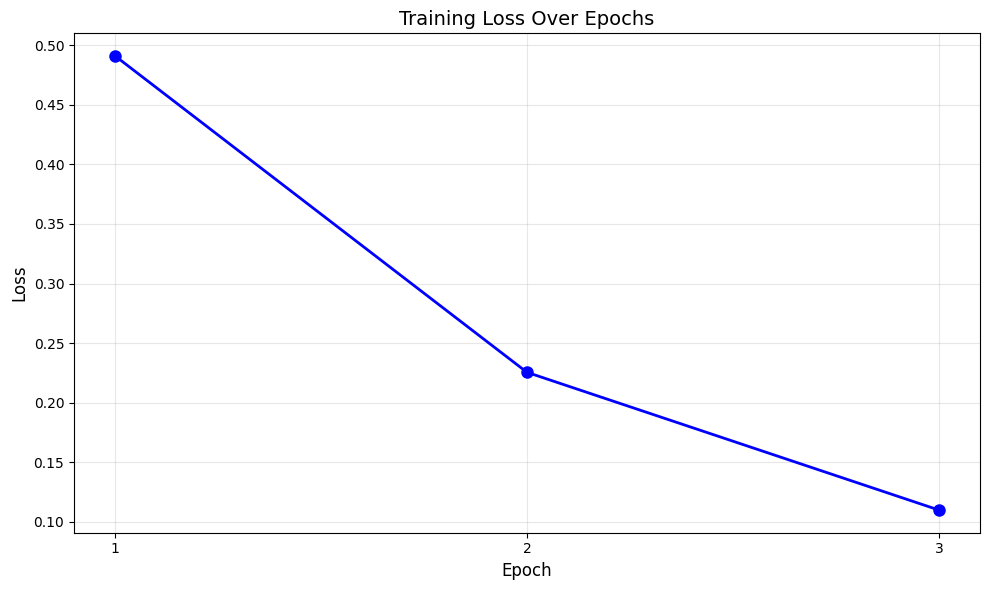


📉 Training Loss Summary:
   Epoch 1: 0.4909
   Epoch 2: 0.2255
   Epoch 3: 0.1100


In [18]:
# Visualize training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'b-o', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14)
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📉 Training Loss Summary:")
for i, loss in enumerate(train_losses):
    print(f"   Epoch {i+1}: {loss:.4f}")

---

## 📈 Part 9: Evaluate the Model

In [19]:
# Evaluate the model
accuracy = evaluate_model(model, eval_dataloader)

print("\n📈 Final Evaluation Results:")
print("=" * 50)
print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

📊 Evaluating model...


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]


📈 Final Evaluation Results:
   Accuracy: 0.9060 (90.60%)


---

## 💾 Part 10: Save the Model

In [20]:
# Save the model and tokenizer
MODEL_SAVE_PATH = "./bert_ag_news_model"

model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

# Also save the full model state dict
torch.save(model.state_dict(), f"{MODEL_SAVE_PATH}/model_state_dict.pt")

print(f"✅ Model saved to: {MODEL_SAVE_PATH}")

✅ Model saved to: ./bert_ag_news_model


---

## 🔮 Part 11: Inference with the Fine-tuned Model

Now let's test our model on some new news headlines!

In [21]:
def predict_news_topic(text):
    """
    Predicts the topic category for a news article.
    
    Args:
        text: The news article or headline text
        
    Returns:
        A dictionary with predicted topic and confidence
    """
    # Set model to evaluation mode
    model.eval()
    
    # Tokenize the input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    )
    
    # Move inputs to device
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return {
        "topic": label_names[predicted_class],
        "topic_id": predicted_class,
        "confidence": confidence,
        "all_probabilities": {
            label_names[i]: f"{prob:.2%}" 
            for i, prob in enumerate(probabilities[0].cpu().numpy())
        }
    }

In [22]:
# Test headlines - one from each category
test_headlines = [
    # World news
    "UN Security Council meets to discuss Middle East peace negotiations.",
    
    # Sports news
    "Manchester United defeats Liverpool 3-2 in thrilling Premier League match.",
    
    # Business news
    "Stock markets rally as Federal Reserve signals potential interest rate cuts.",
    
    # Science/Tech news
    "NASA's James Webb telescope discovers water vapor on distant exoplanet.",
    
    # Additional examples
    "Apple announces record quarterly earnings driven by strong iPhone sales.",
    "OpenAI releases GPT-5 with unprecedented language understanding.",
    "Earthquake magnitude 7.2 strikes coastal region, tsunami warning issued.",
    "LeBron James becomes NBA's all-time leading scorer."
]

print("🗞️ News Topic Classification Results")
print("=" * 70)

for i, headline in enumerate(test_headlines, 1):
    result = predict_news_topic(headline)
    print(f"\n📰 Article {i}:")
    print(f"   \"{headline[:60]}...\"" if len(headline) > 60 else f"   \"{headline}\"")
    print(f"   → Predicted Topic: {result['topic']}")
    print(f"   → Confidence: {result['confidence']:.2%}")

🗞️ News Topic Classification Results

📰 Article 1:
   "UN Security Council meets to discuss Middle East peace negot..."
   → Predicted Topic: 🌍 World
   → Confidence: 99.63%

📰 Article 2:
   "Manchester United defeats Liverpool 3-2 in thrilling Premier..."
   → Predicted Topic: ⚽ Sports
   → Confidence: 90.06%

📰 Article 3:
   "Stock markets rally as Federal Reserve signals potential int..."
   → Predicted Topic: 💼 Business
   → Confidence: 98.04%

📰 Article 4:
   "NASA's James Webb telescope discovers water vapor on distant..."
   → Predicted Topic: 🔬 Sci/Tech
   → Confidence: 99.19%

📰 Article 5:
   "Apple announces record quarterly earnings driven by strong i..."
   → Predicted Topic: 🔬 Sci/Tech
   → Confidence: 85.06%

📰 Article 6:
   "OpenAI releases GPT-5 with unprecedented language understand..."
   → Predicted Topic: 🔬 Sci/Tech
   → Confidence: 99.34%

📰 Article 7:
   "Earthquake magnitude 7.2 strikes coastal region, tsunami war..."
   → Predicted Topic: 🌍 World
   → Confidence

In [23]:
# Detailed prediction with all probabilities
sample_text = "Tesla stock surges 15% after announcing breakthrough in battery technology."

result = predict_news_topic(sample_text)

print("🔍 Detailed Prediction Analysis")
print("=" * 50)
print(f"\nText: {sample_text}")
print(f"\n📊 Predicted Topic: {result['topic']}")
print(f"\n📈 Probability Distribution:")
for topic, prob in result['all_probabilities'].items():
    bar_length = int(float(prob.strip('%')) / 5)
    bar = "█" * bar_length
    print(f"   {topic}: {prob} {bar}")

🔍 Detailed Prediction Analysis

Text: Tesla stock surges 15% after announcing breakthrough in battery technology.

📊 Predicted Topic: 💼 Business

📈 Probability Distribution:
   🌍 World: 2.48% 
   ⚽ Sports: 0.10% 
   💼 Business: 55.01% ███████████
   🔬 Sci/Tech: 42.41% ████████


---

## 🤗 Part 12: Using Pipeline for Easy Inference

Hugging Face provides a convenient `pipeline` API for even simpler inference.

In [24]:
from transformers import pipeline

# Create a text classification pipeline
classifier = pipeline(
    "text-classification", 
    model=MODEL_SAVE_PATH,
    device=0 if torch.cuda.is_available() else -1,
    top_k=None  # Return all classes with probabilities
)

print("✅ Pipeline created!")

Device set to use cuda:0


✅ Pipeline created!


In [26]:
# Quick classification with pipeline
news_articles = [
    "Scientists develop new AI algorithm that can predict weather patterns.",
    "Brazil wins World Cup after penalty shootout against Argentina.",
    "Amazon acquires competitor in $50 billion deal."
]

print("🚀 Quick Classification with Pipeline")
print("=" * 50)

results = classifier(news_articles, batch_size=8, truncation=True)

for article, scores in zip(news_articles, results):
    top = max(scores, key=lambda x: x["score"])
    print(f"\n📰 {article[:50]}...")
    print(f"   → {top['label']} ({top['score']:.2%})")


🚀 Quick Classification with Pipeline

📰 Scientists develop new AI algorithm that can predi...
   → Sci/Tech (97.74%)

📰 Brazil wins World Cup after penalty shootout again...
   → Sports (96.86%)

📰 Amazon acquires competitor in $50 billion deal....
   → Business (77.08%)


---

## 🎓 Summary

### What We Accomplished:

1. **Loaded and tokenized** the AG News dataset using BERT tokenizer
2. **Created custom PyTorch DataLoaders** for efficient batching
3. **Implemented a custom training loop** with AdamW optimizer and linear LR scheduler
4. **Fine-tuned BERT** for 4-class news classification
5. **Evaluated model accuracy** using torchmetrics
6. **Built inference functions** for predicting on new articles

### Key Takeaways:

| Component | Description |
|-----------|-------------|
| Custom Training Loop | Full control over training process |
| AdamW Optimizer | Weight decay regularization for transformers |
| Linear LR Scheduler | Gradually decreases learning rate |
| DataLoader | Efficient batch processing |

### Next Steps:

- Train on the full dataset for better accuracy
- Try different learning rates and batch sizes
- Implement early stopping based on validation loss
- Add more evaluation metrics (F1, confusion matrix)
- Push the model to Hugging Face Hub

---

## 📚 References & Resources

- [BERT Paper](https://arxiv.org/abs/1810.04805) - "BERT: Pre-training of Deep Bidirectional Transformers"
- [AG News Dataset](https://huggingface.co/datasets/fancyzhx/ag_news) - Dataset on Hugging Face
- [Hugging Face Transformers](https://huggingface.co/docs/transformers)
- [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)

---